In [1]:
%%capture
%run naive_algorithm.ipynb
%run features_engineering.ipynb

In [2]:
import random 
import seaborn as sns
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

import xgboost as xgb
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


from sklearn.preprocessing import StandardScaler,MinMaxScaler

## Split Train/Test

Probleme de segments dans lequel sont compris d'autres segments , pour eviter de la fuite de données dans le cas ou
segment se retrouverais dans le train et une partie de celui ci dans le train : 

* Calcul de jour calendaire/année de chaque segment
* Selection au hasard de certaines dates qui constitueront le test_set , tout le reste dans le train_set
* De cette maniere aucun segment réalisé a une meme date ne pourra se retrouver a la fois dans le train et le test


In [3]:
segments_df.head(5)

,id,activity_id,athlete_id,name,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,...,climb_category,average_heart_rate,max_heart_rate,start_time,start_date,time_activities_last_30d,type_virtualride,days_since_last_activity,average_climbcat_last_30d,average_speed_last_30d
0,24674235,4831255939,10944546,Champs-Élysées,653,653,6623.10,82.3,202.8,0.0,...,0,161.2,170.0,18:46:25,2021-02-22,315.25,1,0,0.06,7.76
1,27141377,4831057316,10944546,Epic KOM - Start to Bypass Intersection (Zwift...,424,424,1882.50,77.3,201.2,3.8,...,0,157.9,164.0,18:19:40,2021-02-22,315.25,1,2,0.06,7.76
2,22501195,4818094466,10944546,Villenave-Technopole,789,789,5100.50,NaN,108.0,0.5,...,0,169.0,184.0,14:39:32,2021-02-20,262.78,0,3,0.15,7.69
3,3566434,4818094466,10944546,Col du Chateau d'eau,217,217,1190.37,NaN,141.8,2.1,...,0,170.7,183.0,14:40:47,2021-02-20,262.78,0,3,0.15,7.69
4,20598228,4818094466,10944546,Col du chateau d'eau court,151,151,745.40,NaN,165.4,2.8,...,0,177.5,183.0,14:42:02,2021-02-20,262.78,0,3,0.15,7.69


In [4]:
calendar_days = []
for date in segments_df['start_date']:
    calendar_day = date.strftime('%j%Y')
    calendar_days.append(calendar_day)

segments_df['calendar_day'] = calendar_days

In [5]:
dates = segments_df['calendar_day'].unique()

In [6]:
dates = dates.tolist()

In [7]:
ratio_train_test = len(dates) * 0.2
ratio_train_test

40.0

In [8]:
random.seed(42)
dates_test_set = random.sample(dates,int(ratio_train_test))

In [9]:
test_set = segments_df[segments_df['calendar_day'].isin(dates_test_set)]
test_set.shape

(379, 22)

In [10]:
test_set_index = test_set.index
test_set_index

Int64Index([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
            ...
            1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886],
           dtype='int64', length=379)

In [11]:
train_set = segments_df.drop(test_set_index)
train_set

,id,activity_id,athlete_id,name,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,...,average_heart_rate,max_heart_rate,start_time,start_date,time_activities_last_30d,type_virtualride,days_since_last_activity,average_climbcat_last_30d,average_speed_last_30d,calendar_day
0,24674235,4831255939,10944546,Champs-Élysées,653,653,6623.100,82.3,202.8,0.0,...,161.2,170.0,18:46:25,2021-02-22,315.25,1,0,0.06,7.76,0532021
1,27141377,4831057316,10944546,Epic KOM - Start to Bypass Intersection (Zwift...,424,424,1882.500,77.3,201.2,3.8,...,157.9,164.0,18:19:40,2021-02-22,315.25,1,2,0.06,7.76,0532021
27,27180136,4801436758,10944546,Kent Rd Climb to Sprint Banner (Zwift Insider ...,176,176,1137.300,81.4,183.4,2.6,...,149.4,156.0,13:36:00,2021-02-17,254.98,1,5,0.22,7.79,0482021
28,21748007,4801436758,10944546,Yorkshire Sprint Reverse,63,63,394.300,79.9,182.9,2.1,...,153.4,156.0,13:37:53,2021-02-17,254.98,1,5,0.22,7.79,0482021
29,27207377,4801436758,10944546,Finishing Straightaway (Zwift Insider verified),99,99,611.100,78.4,192.3,3.3,...,156.7,162.0,13:40:47,2021-02-17,254.98,1,5,0.22,7.79,0482021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,17782861,1597380847,10944546,RadarStadeMartillac,40,40,303.400,NaN,189.4,1.4,...,176.8,182.0,12:42:52,2018-05-26,0.00,0,0,0.00,0.00,1462018
1936,3654728,1597380847,10944546,Faux plat chemin de Rochemorin,90,90,541.374,NaN,158.9,2.0,...,183.6,188.0,12:47:30,2018-05-26,0.00,0,0,0.00,0.00,1462018
1937,3752963,1597380847,10944546,Imitationberg,141,141,872.000,NaN,82.3,-0.0,...,168.2,184.0,12:53:34,2018-05-26,0.00,0,0,0.00,0.00,1462018
1938,14775448,1597380847,10944546,Château Vignau - Chemin de Couhins,226,226,1431.800,NaN,84.4,-0.6,...,155.2,186.0,12:56:14,2018-05-26,0.00,0,0,0.00,0.00,1462018


In [12]:
1561/1940

0.804639175257732

## Model

In [13]:
columns = ['elapsed_time','distance','average_grade','climb_category','time_activities_last_30d','type_virtualride','days_since_last_activity','average_speed_last_30d','average_climbcat_last_30d']
corrmat = train_set[columns].corr()
corrmat

,elapsed_time,distance,average_grade,climb_category,time_activities_last_30d,type_virtualride,days_since_last_activity,average_speed_last_30d,average_climbcat_last_30d
elapsed_time,1.000000,0.867961,0.179051,0.861286,-0.071526,0.296199,-0.037132,0.147205,0.034775
distance,0.867961,1.000000,-0.100558,0.582509,-0.018262,0.230796,-0.031812,0.079122,0.052726
average_grade,0.179051,-0.100558,1.000000,0.342676,0.105908,0.534938,-0.161513,0.260077,0.085085
climb_category,0.861286,0.582509,0.342676,1.000000,-0.090750,0.334232,-0.037436,0.178877,0.021877
time_activities_last_30d,-0.071526,-0.018262,0.105908,-0.090750,1.000000,0.190333,-0.398828,0.308430,-0.110501
type_virtualride,0.296199,0.230796,0.534938,0.334232,0.190333,1.000000,-0.268455,0.389918,0.127300
days_since_last_activity,-0.037132,-0.031812,-0.161513,-0.037436,-0.398828,-0.268455,1.000000,-0.656621,0.093495
average_speed_last_30d,0.147205,0.079122,0.260077,0.178877,0.308430,0.389918,-0.656621,1.000000,-0.021749
average_climbcat_last_30d,0.034775,0.052726,0.085085,0.021877,-0.110501,0.127300,0.093495,-0.021749,1.000000


In [14]:
columns = ['elapsed_time','distance','climb_category','type_virtualride','time_activities_last_30d','days_since_last_activity','average_climbcat_last_30d']
# columns = ['elapsed_time','distance']
train_set = train_set[columns]
test_set = test_set[columns]

In [15]:
y_train = train_set["elapsed_time"]
X_train = train_set.drop("elapsed_time", axis=1)
y_test  = test_set["elapsed_time"]
X_test = test_set.drop("elapsed_time", axis=1)


print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(1561,)
(1561, 6)
(379,)
(379, 6)


In [16]:
X_train.head(5)

,distance,climb_category,type_virtualride,time_activities_last_30d,days_since_last_activity,average_climbcat_last_30d
0,6623.1,0,1,315.25,0,0.06
1,1882.5,0,1,315.25,2,0.06
27,1137.3,0,1,254.98,5,0.22
28,394.3,0,1,254.98,5,0.22
29,611.1,0,1,254.98,5,0.22


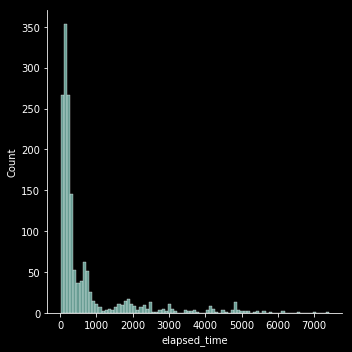

In [19]:
sns.displot(y_train)

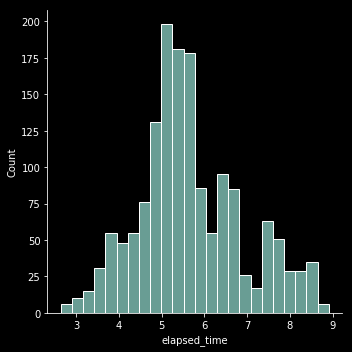

In [20]:
sns.displot(np.log(y_train))

In [21]:
y_train_log = np.log(y_train)

## Scaler ##

In [ ]:
# min_max = MinMaxScaler()

In [ ]:
# min_max.fit(X_train)

In [ ]:
# X_train_scaled = min_max.transform(X_train)
# X_test_scaled = min_max.transform(X_test)

#### Algos

In [23]:
reg = LinearRegression()
reg.fit(X_train,y_train_log)
y_pred_reg_log = reg.predict(X_test)

In [24]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train,y_train_log)
y_pred_xgb_log = xgb_reg.predict(X_test)

In [25]:
forrest_reg = RandomForestRegressor()
forrest_reg.fit(X_train,y_train_log)
y_pred_forrest_log = forrest_reg.predict(X_test)

In [26]:
mae_reg = mean_absolute_error(y_test,np.exp(y_pred_reg_log))
mape_reg = mean_absolute_percentage_error(y_test, np.exp(y_pred_reg_log))
rmse_reg  = np.sqrt(mean_squared_error(y_test,np.exp(y_pred_reg_log)))
print(f'mae_reg : {mae_reg}')
print(f'mape_reg : {mape_reg}')
print(f'rmse_reg: {rmse_reg}')

mae_reg : 290.3879648848965
mape_reg : 0.8811885359546777
rmse_reg: 752.2295522867147


In [27]:
mae_xgb = mean_absolute_error(y_test,np.exp(y_pred_xgb_log))
mape_xgb = mean_absolute_percentage_error(y_test, np.exp(y_pred_xgb_log))
rmse_xgb  = np.sqrt(mean_squared_error(y_test,np.exp(y_pred_xgb_log)))
print(f'mae_xgb : {mae_xgb}')
print(f'mape_xgb: {mape_xgb}')
print(f'rmse_xgb: {rmse_xgb}')

mae_xgb : 78.15641806308072
mape_xgb: 0.20178541310302212
rmse_xgb: 144.9026195023601


In [28]:
mae_forrest = mean_absolute_error(y_test,np.exp(y_pred_forrest_log))
mape_forrest = mean_absolute_percentage_error(y_test, np.exp(y_pred_forrest_log))
rmse_forrest  = np.sqrt(mean_squared_error(y_test,np.exp(y_pred_forrest_log)))
print(f'mae_forrest : {mae_forrest}')
print(f'mape_forrest: {mape_forrest}')
print(f'rmse_forrest: {rmse_forrest}')

mae_forrest : 76.5695257160851
mape_forrest: 0.1925832702663408
rmse_forrest: 153.42990461663635


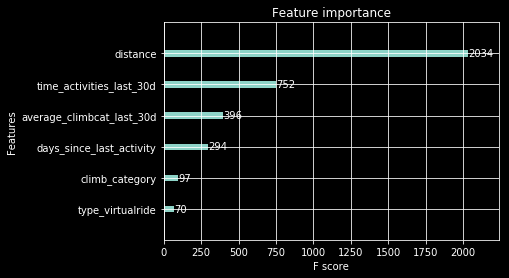

In [29]:
xgb.plot_importance(xgb_reg)
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

In [30]:
data = {
    'MAE':[mae_naive,mae_reg,mae_xgb,mae_forrest],
    'MAPE':[mape_naive,mape_reg,mape_xgb,mape_forrest],
    'RMSE':[rmse_naive,rmse_reg,rmse_xgb,rmse_forrest]
}

comparaison_df = pd.DataFrame(data, index=['naive','linreg','xgbreg','forrest'])
comparaison_df.sort_values(by=['MAPE'])

,MAE,MAPE,RMSE
forrest,76.569526,0.192583,153.429905
xgbreg,78.156418,0.201785,144.902620
naive,202.259702,0.372339,464.705005
linreg,290.387965,0.881189,752.229552


### Prediction Alpe d'huez

In [ ]:
query = {
    "query": {
        "match": {
            "_id": 2787335981548134218
        }
    }
}

result = database.search(
    index="index_route",
    size=1000,
    body= query
)

route_alpe = result['hits']['hits'][0]['_source']
segments_alpe = route_alpe.get("segmentation")
segments_alpe_df = pd.DataFrame(segments_alpe)
segments_alpe_df

**Time Activities last 30d and Avg Speed**

In [ ]:
today = date.today()
end_date = today - timedelta(days=1)
start_date = end_date - timedelta(days=30)

In [ ]:
activities_last_30d = activities_df[activities_df['start_date'].between(start_date,end_date)]
time_activities_last_30d = round((activities_last_30d['elapsed_time'].sum()/60),2)

result = activities_last_30d['average_speed'].mean()
if np.isnan(result):
    average_speed_last_30d = 0
else:
    average_speed_last_30d = result

In [ ]:
segments_alpe_df['time_activities_last_30d'] = time_activities_last_30d
segments_alpe_df['average_speed_last_30d'] = average_speed_last_30d
segments_alpe_df

**Home Trainer**

In [ ]:
segments_alpe_df['type_virtualride'] = 1
segments_alpe_df

**Climb Category**

In [ ]:
climb_category = []
for average_grade, distance in zip(segments_alpe_df['average_grade'],segments_alpe_df['distance']):
    result = average_grade * distance
    if result <= 8000:
        climb_cat = 0
    elif result > 8000 and result <= 16000:
        climb_cat = 4
    elif result > 16000 and result <= 32000:
        climb_cat = 3
    elif result > 32000 and result <= 64000:
        climb_cat = 2
    elif result > 64000 and result <= 80000:
        climb_cat = 1
    elif result > 80000:
        climb_cat = 5
    climb_category.append(climb_cat)
climb_category

In [ ]:
segments_alpe_df['climb_category'] = climb_category
segments_alpe_df

**Days since last_activities**

In [ ]:
result = date.today() - activities_df.loc[0]['start_date']
segments_alpe_df['days_since_last_activity'] = result.days
segments_alpe_df

**AVg climb Last30D**

In [ ]:
segments_alpe_df['average_climbcat_last_30d'] = round(segments_df[segments_df['start_date'].between(start_date,end_date)]['climb_category'].mean(),2)

**Prediction**

In [ ]:
cols_to_predict = ['distance','climb_category','type_virtualride','time_activities_last_30d','days_since_last_activity','average_climbcat_last_30d']
datas = segments_alpe_df[cols_to_predict]
datas

In [ ]:
alpe_pred_reg = reg.predict(datas)
elapsed_time_reg = relativedelta(seconds=(np.exp(alpe_pred_reg)).sum())
elapsed_time_reg

In [ ]:
alpe_pred_xgb = xgb_reg.predict(datas)
elapsed_time_xgb = relativedelta(seconds=(np.exp(alpe_pred_xgb)).sum())
elapsed_time_xgb

In [ ]:
alpe_pred_forrest = forrest_reg.predict(datas)
elapsed_time_forrest = relativedelta(seconds=(np.exp(alpe_pred_forrest)).sum())
elapsed_time_forrest

In [ ]:
elapsed_time_naive

In [ ]:
def format_hms_relativedelta(relative_delta):
    hour = int(relative_delta.hours)
    minutes = int(relative_delta.minutes)
    seconds = int(relative_delta.seconds)
    print(f'Prediction {hour}h{minutes}m{seconds}sec')
    return f'{hour}h{minutes}m{seconds}sec'

In [ ]:
def compute_kmh(time,distance):
    return (distance/time)*3.6

In [ ]:
def compute_pred_seconds(pred):
    return round(np.exp(pred).sum(),2)

In [ ]:
distance = segments_alpe_df['distance'].sum()
distance

In [ ]:
data = {
    'Prediction':[
                  format_hms_relativedelta(elapsed_time_naive),
                  format_hms_relativedelta(elapsed_time_reg),
                  format_hms_relativedelta(elapsed_time_xgb),
                  format_hms_relativedelta(elapsed_time_forrest),
                  '0h31m39s'
                 ],
    'Mean_speed(km/h)':[
                        distance / elapsed_time_pred_naive_sec * 3.6,
                        compute_kmh(compute_pred_seconds(alpe_pred_reg),distance),
                        compute_kmh(compute_pred_seconds(alpe_pred_xgb),distance),
                        compute_kmh(compute_pred_seconds(alpe_pred_forrest),distance),
                        distance / 1899 * 3.6
                        ]
}

comparaison_pred_df = pd.DataFrame(data, index=['naive','linreg','xgbreg','forrest','strava'])
comparaison_pred_df